# 00. Data Strategy & Visual Evidence

## Mục tiêu
Notebook này thực hiện quy trình khoa học đúng đắn:

**Quan sát (Visualize) → Ra quyết định (Decision) → Code (Implement)**

Mọi quyết định tiền xử lý đều phải có **Data Evidence** chống lưng.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath('../src'))
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

df_raw = pd.read_csv('../data/raw/global-data-on-sustainable-energy.csv')
print(f"Loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
print(f"Entities: {df_raw['Entity'].nunique()}")
print(f"Years: {df_raw['Year'].min()} - {df_raw['Year'].max()}")

Loaded: 3649 rows, 21 columns
Entities: 176
Years: 2000 - 2020


## 1. Phân tích Missing Values

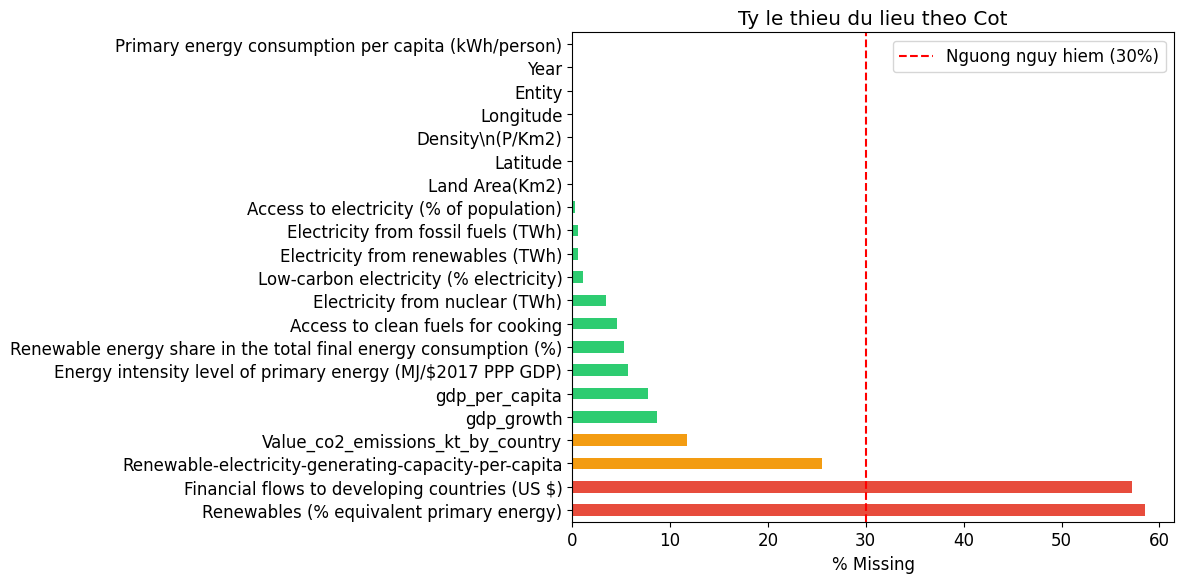

COT CO VAN DE (>30% thieu): ['Renewables (% equivalent primary energy)', 'Financial flows to developing countries (US $)']


In [2]:
# Missing Rate by Column
missing_pct = (df_raw.isnull().sum() / len(df_raw) * 100).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = ['#e74c3c' if x > 30 else '#f39c12' if x > 10 else '#2ecc71' for x in missing_pct.values]
missing_pct.plot(kind='barh', color=colors)
plt.title('Ty le thieu du lieu theo Cot')
plt.xlabel('% Missing')
plt.axvline(30, color='red', linestyle='--', label='Nguong nguy hiem (30%)')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/missing_by_column.png', dpi=150)
plt.show()

problem_cols = missing_pct[missing_pct > 30].index.tolist()
print(f"COT CO VAN DE (>30% thieu): {problem_cols}")

## 2. Phân tích Chất lượng Dữ liệu theo Quốc gia

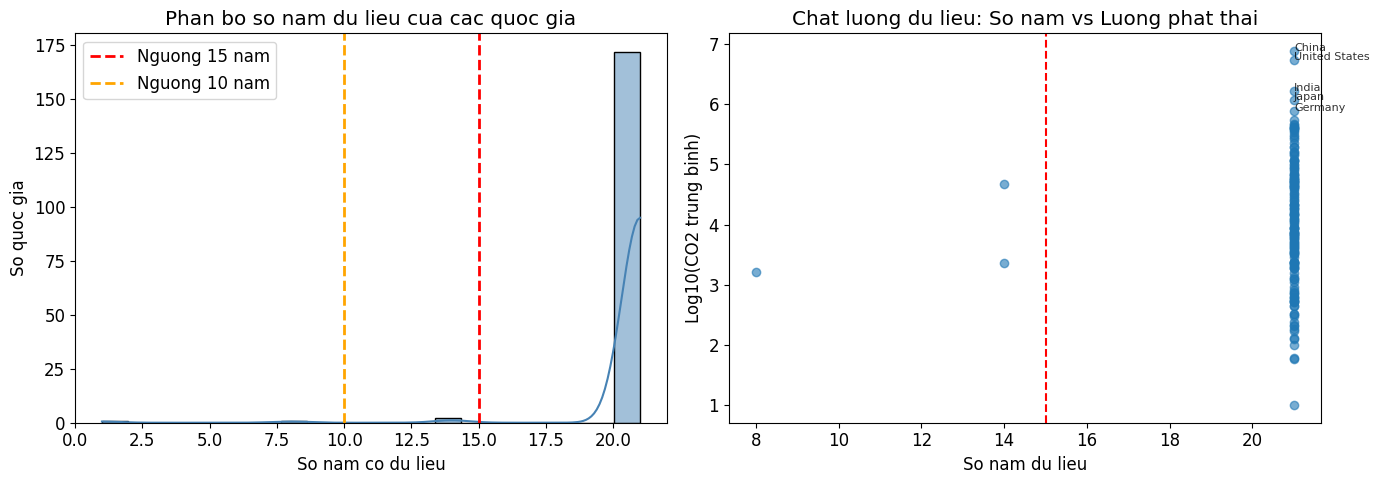

Tong quoc gia: 176
Co >= 15 nam: 172
Co >= 10 nam: 174
Co < 10 nam: 2


In [3]:
target_col = 'Value_co2_emissions_kt_by_country'

stats = df_raw.groupby('Entity').agg({
    'Year': 'count',
    target_col: 'mean'
}).rename(columns={'Year': 'Years_Count', target_col: 'CO2_Mean'})
stats = stats.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Years Count
ax1 = axes[0]
sns.histplot(stats['Years_Count'], bins=21, kde=True, ax=ax1, color='steelblue')
ax1.set_title('Phan bo so nam du lieu cua cac quoc gia')
ax1.set_xlabel('So nam co du lieu')
ax1.set_ylabel('So quoc gia')
ax1.axvline(15, color='red', linestyle='--', linewidth=2, label='Nguong 15 nam')
ax1.axvline(10, color='orange', linestyle='--', linewidth=2, label='Nguong 10 nam')
ax1.legend()

# Scatter: CO2 Mean vs Years Count
ax2 = axes[1]
scatter = ax2.scatter(stats['Years_Count'], 
                      np.log10(stats['CO2_Mean'].clip(lower=1)), 
                      alpha=0.6)
ax2.set_xlabel('So nam du lieu')
ax2.set_ylabel('Log10(CO2 trung binh)')
ax2.set_title('Chat luong du lieu: So nam vs Luong phat thai')
ax2.axvline(15, color='red', linestyle='--', label='Nguong cat')

major = ['China', 'United States', 'India', 'Germany', 'Japan']
for country in major:
    row = stats[stats['Entity'] == country]
    if not row.empty:
        ax2.annotate(country, 
                     (row['Years_Count'].values[0], np.log10(row['CO2_Mean'].values[0])),
                     fontsize=8, alpha=0.8)

plt.tight_layout()
plt.savefig('../reports/figures/data_quality_analysis.png', dpi=150)
plt.show()

print(f"Tong quoc gia: {len(stats)}")
print(f"Co >= 15 nam: {(stats['Years_Count'] >= 15).sum()}")
print(f"Co >= 10 nam: {(stats['Years_Count'] >= 10).sum()}")
print(f"Co < 10 nam: {(stats['Years_Count'] < 10).sum()}")

In [4]:
# Countries to drop if using 15-year threshold
countries_to_drop = stats[stats['Years_Count'] < 15]['Entity'].tolist()
print(f"Quoc gia bi loai neu dung nguong 15 nam ({len(countries_to_drop)}):")
print(countries_to_drop)

major_economies = ['China', 'United States', 'India', 'Germany', 'Japan', 'United Kingdom', 
                   'France', 'Italy', 'Brazil', 'Canada', 'South Korea', 'Australia']
major_at_risk = [c for c in major_economies if c in countries_to_drop]
print(f"Nuoc lon co nguy co bi loai: {major_at_risk if major_at_risk else 'Khong co'}")

Quoc gia bi loai neu dung nguong 15 nam (4):
['French Guiana', 'Montenegro', 'Serbia', 'South Sudan']
Nuoc lon co nguy co bi loai: Khong co


## 3. Phân tích Skewness - Log Transform

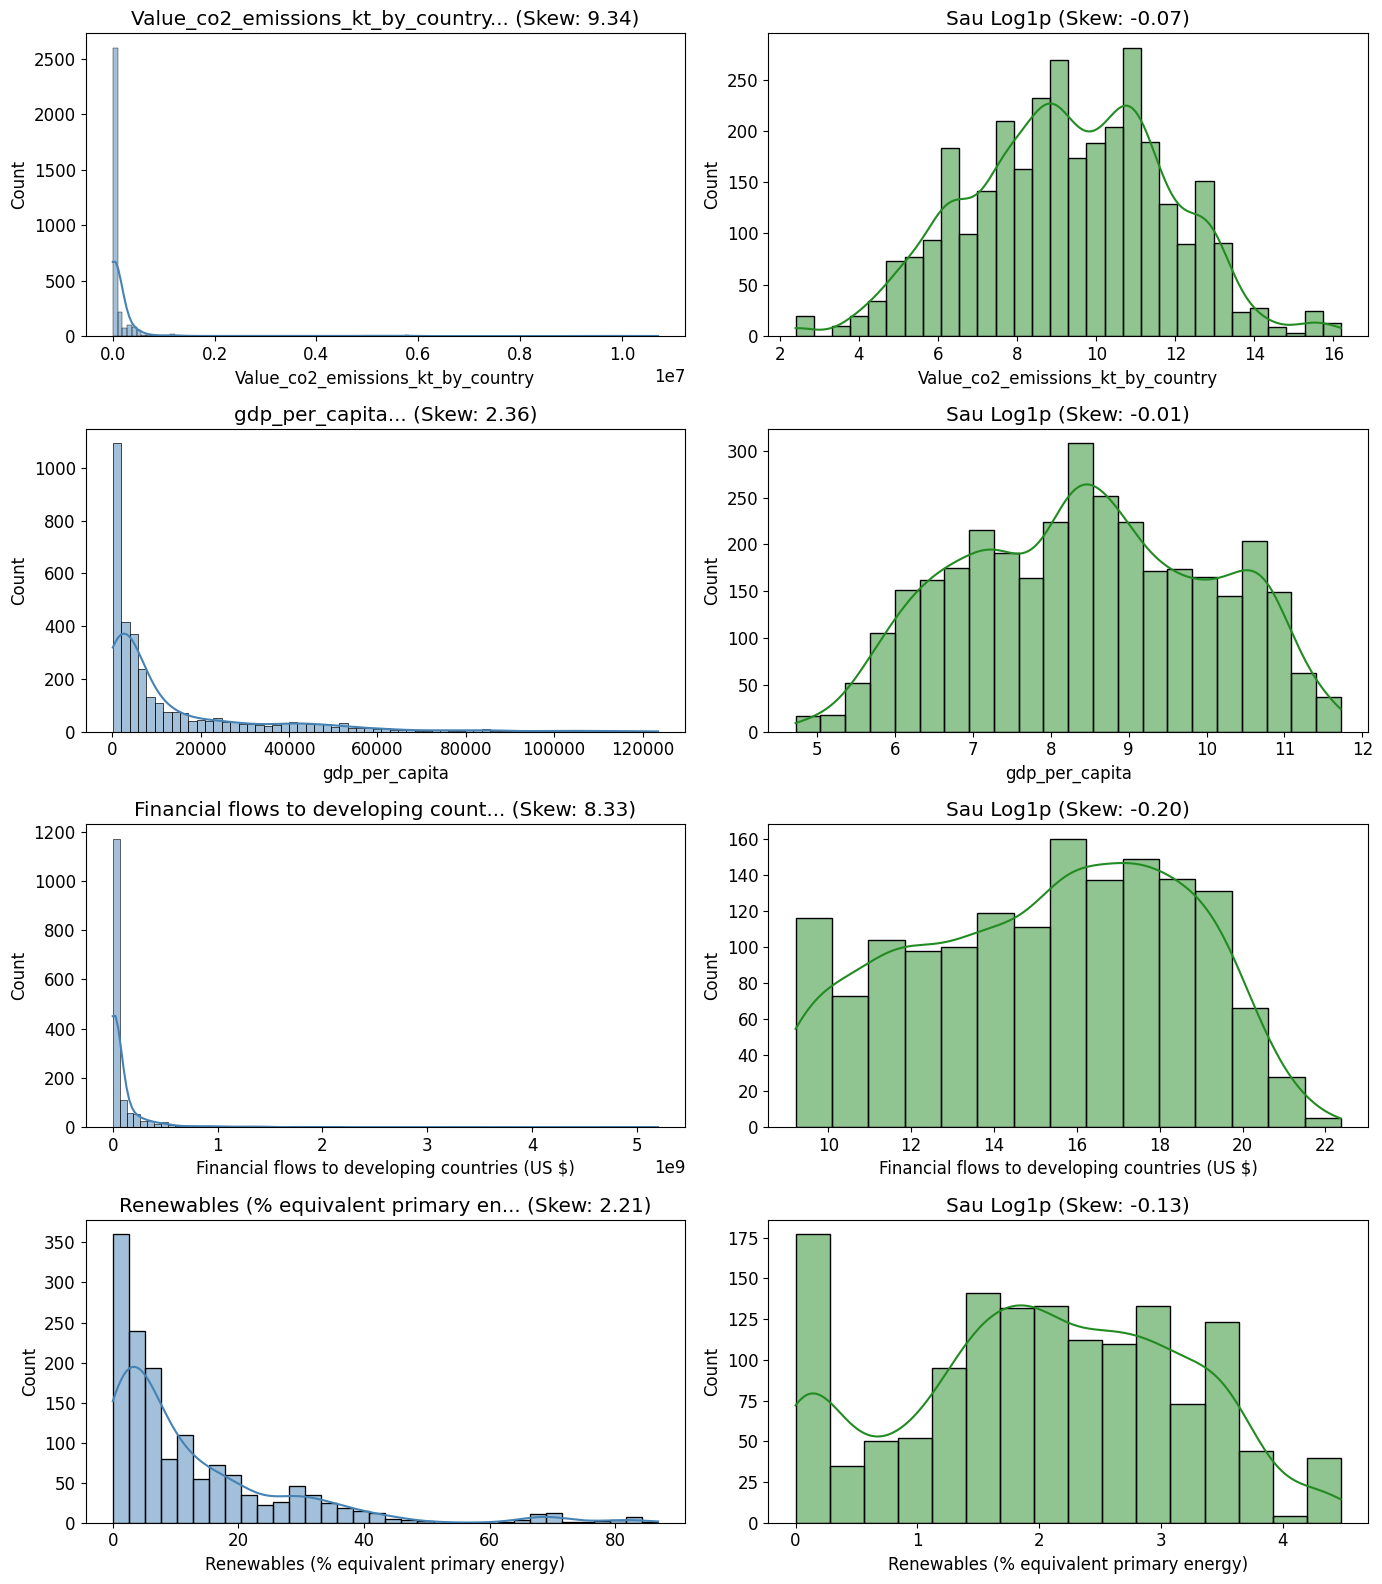

BANG PHAN TICH SKEWNESS:
                                        Column  Original_Skew  Log_Skew  Need_Log
             Value_co2_emissions_kt_by_country       9.337673 -0.065644      True
                                gdp_per_capita       2.359599 -0.012002      True
Financial flows to developing countries (US $)       8.326408 -0.197343      True
      Renewables (% equivalent primary energy)       2.207488 -0.129763      True


In [5]:
cols_to_check = [
    'Value_co2_emissions_kt_by_country',
    'gdp_per_capita',
    'Financial flows to developing countries (US $)',
    'Renewables (% equivalent primary energy)'
]

available_cols = [c for c in cols_to_check if c in df_raw.columns]
fig, axes = plt.subplots(len(available_cols), 2, figsize=(14, 4*len(available_cols)))

skew_results = []
for i, col in enumerate(available_cols):
    data = df_raw[col].dropna()
    data = data[data > 0]
    
    # Before Log
    sns.histplot(data, kde=True, ax=axes[i, 0], color='steelblue')
    axes[i, 0].set_title(f'{col[:35]}... (Skew: {data.skew():.2f})')
    
    # After Log
    log_data = np.log1p(data)
    sns.histplot(log_data, kde=True, ax=axes[i, 1], color='forestgreen')
    axes[i, 1].set_title(f'Sau Log1p (Skew: {log_data.skew():.2f})')
    
    skew_results.append({'Column': col, 'Original_Skew': data.skew(), 'Log_Skew': log_data.skew()})

plt.tight_layout()
plt.savefig('../reports/figures/skewness_analysis.png', dpi=150)
plt.show()

skew_df = pd.DataFrame(skew_results)
skew_df['Need_Log'] = skew_df['Original_Skew'].abs() > 1
print("BANG PHAN TICH SKEWNESS:")
print(skew_df.to_string(index=False))

## 4. Phân tích Outliers

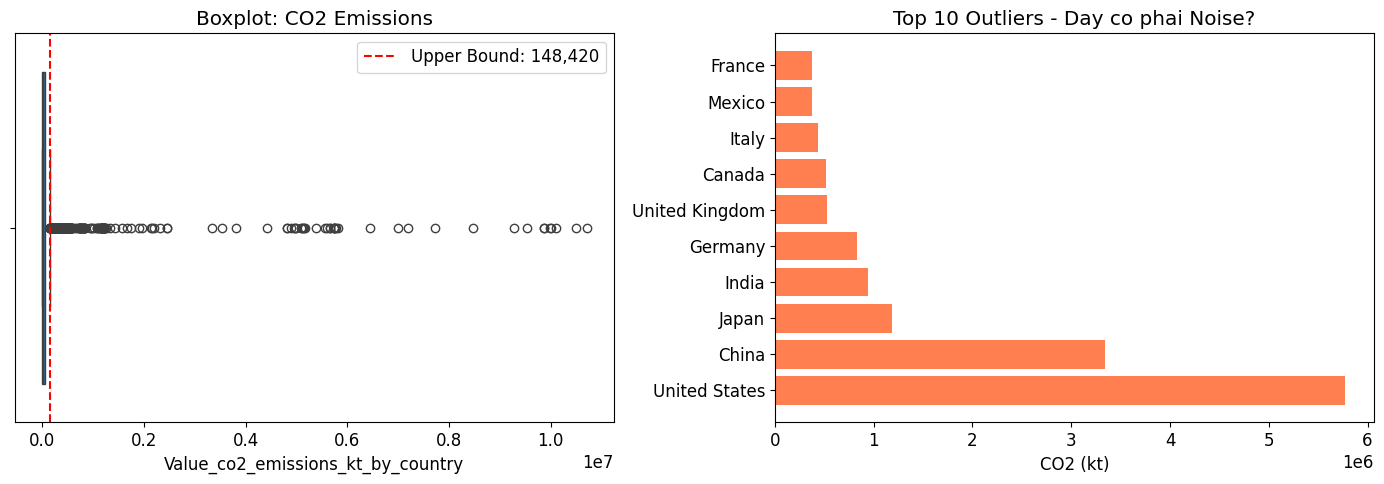

TOP OUTLIERS (CO2):
              Entity  Value_co2_emissions_kt_by_country
3502   United States                          5775810.0
714            China                          3346530.0
1681           Japan                          1182610.0
1534           India                           937860.0
1282         Germany                           830280.0
3481  United Kingdom                           530890.0
609           Canada                           514220.0
1639           Italy                           436300.0
2143          Mexico                           379180.0
1197          France                           373120.0


In [6]:
target = 'Value_co2_emissions_kt_by_country'
data = df_raw[target].dropna()

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
ax1 = axes[0]
sns.boxplot(x=data, ax=ax1)
ax1.set_title(f'Boxplot: CO2 Emissions')
ax1.axvline(upper, color='red', linestyle='--', label=f'Upper Bound: {upper:,.0f}')
ax1.legend()

# Top outliers
outliers = df_raw[df_raw[target] > upper][['Entity', target]].drop_duplicates('Entity').nlargest(10, target)

ax2 = axes[1]
if not outliers.empty:
    ax2.barh(outliers['Entity'], outliers[target], color='coral')
    ax2.set_title('Top 10 Outliers - Day co phai Noise?')
    ax2.set_xlabel('CO2 (kt)')

plt.tight_layout()
plt.savefig('../reports/figures/outlier_analysis.png', dpi=150)
plt.show()

print("TOP OUTLIERS (CO2):")
print(outliers)

## 5. Phân tích Multicollinearity

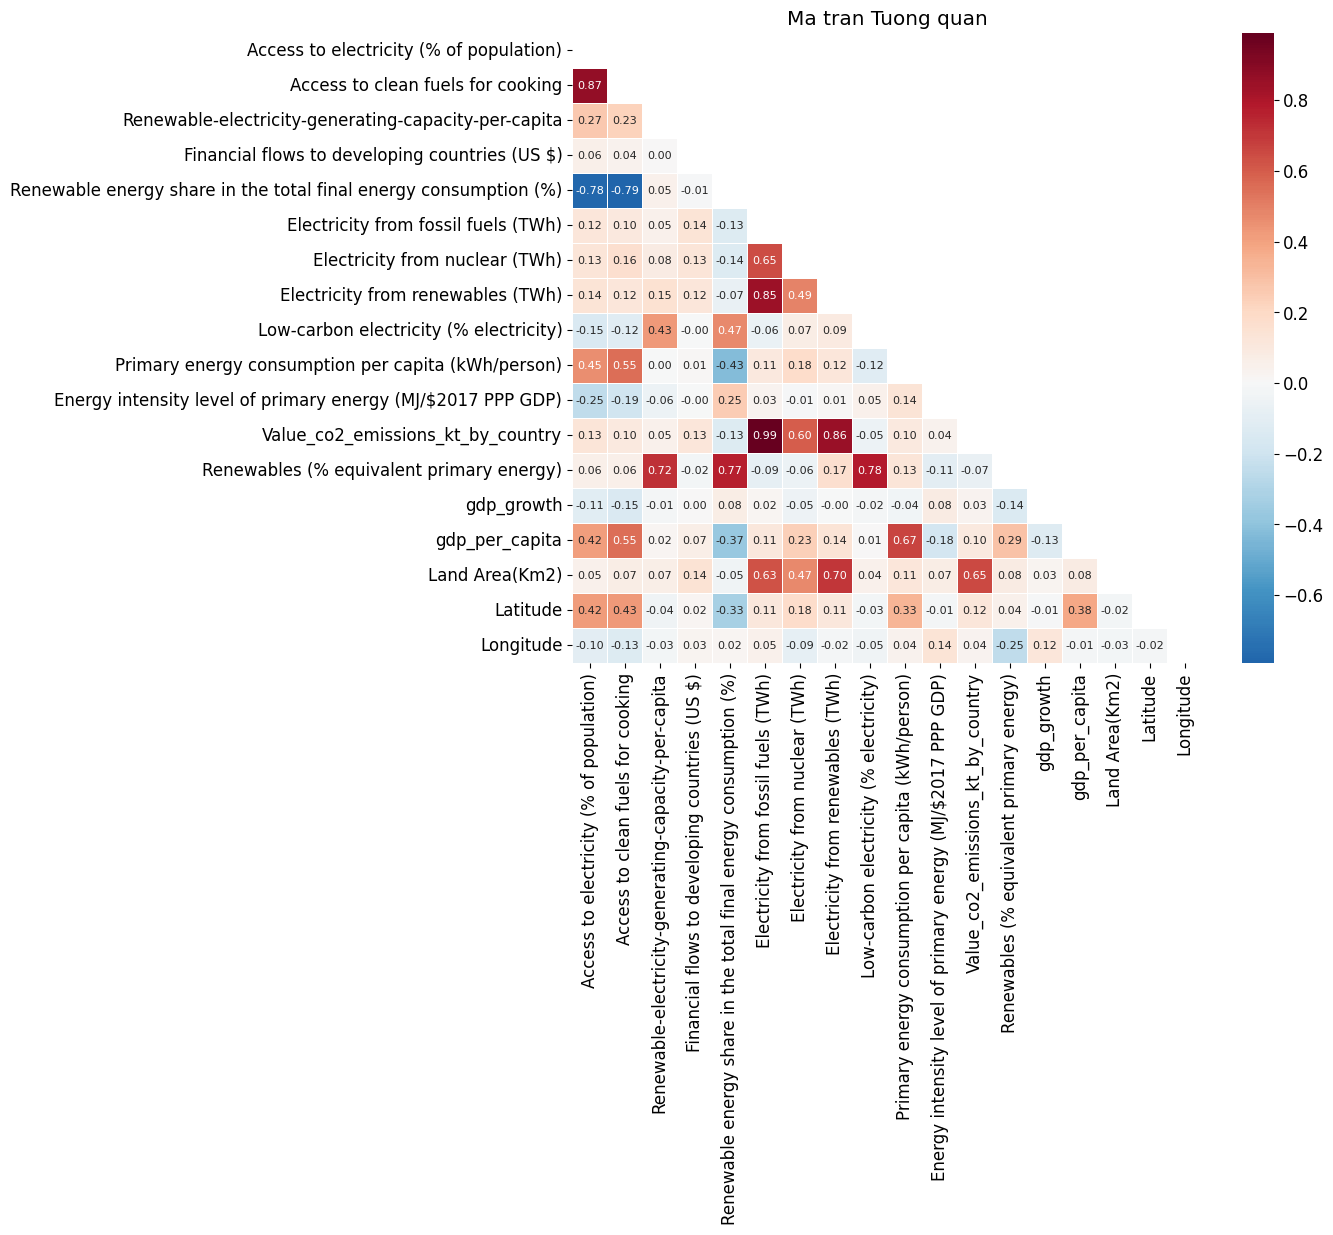

CAP BIEN TUONG QUAN CAO (|r| > 0.7):
                                                            Var1                                                             Var2  Correlation
                             Electricity from fossil fuels (TWh)                                Value_co2_emissions_kt_by_country     0.989741
                         Access to electricity (% of population)                                Access to clean fuels for cooking     0.866554
                               Electricity from renewables (TWh)                                Value_co2_emissions_kt_by_country     0.856270
                             Electricity from fossil fuels (TWh)                                Electricity from renewables (TWh)     0.845067
                          Low-carbon electricity (% electricity)                         Renewables (% equivalent primary energy)     0.782388
Renewable energy share in the total final energy consumption (%)                         Renewables (% eq

In [7]:
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
if 'Year' in numeric_cols:
    numeric_cols.remove('Year')

corr = df_raw[numeric_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5,
            annot_kws={'size': 8})
plt.title('Ma tran Tuong quan')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', dpi=150)
plt.show()

# Find highly correlated pairs
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.7:
            high_corr.append({
                'Var1': corr.columns[i],
                'Var2': corr.columns[j],
                'Correlation': corr.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', ascending=False)
print("CAP BIEN TUONG QUAN CAO (|r| > 0.7):")
print(high_corr_df.to_string(index=False))

## 6. TỔNG HỢP CHIẾN LƯỢC

In [8]:
print("""
==========================================================================
                    CHIEN LUOC TIEN XU LY (Data-Driven)
==========================================================================
1. LOAI BO QUOC GIA
   Quy tac: Giu quoc gia co >= 15 nam du lieu
   Bang chung: Hinh data_quality_analysis.png
   -> Day la Whitelist TU NHIEN

2. XU LY MISSING VALUES
   Phuong phap: Interpolation cho Time-series / Median cho Cross-section
   Bang chung: Hinh missing_by_column.png

3. LOG TRANSFORM
   Ap dung cho: Financial flows, Renewables (Skew > 1)
   KHONG ap dung: CO2, GDP
   Bang chung: Hinh skewness_analysis.png

4. OUTLIER HANDLING
   KHONG dung IQR cho Target (CO2)
   Ly do: Top outliers = Top emitters = SIGNAL, not NOISE
   Bang chung: Hinh outlier_analysis.png

5. MULTICOLLINEARITY
   Loai bo: Xem correlation_matrix.png
   Bang chung: Hinh correlation_matrix.png
==========================================================================
""")


                    CHIEN LUOC TIEN XU LY (Data-Driven)
1. LOAI BO QUOC GIA
   Quy tac: Giu quoc gia co >= 15 nam du lieu
   Bang chung: Hinh data_quality_analysis.png
   -> Day la Whitelist TU NHIEN

2. XU LY MISSING VALUES
   Phuong phap: Interpolation cho Time-series / Median cho Cross-section
   Bang chung: Hinh missing_by_column.png

3. LOG TRANSFORM
   Ap dung cho: Financial flows, Renewables (Skew > 1)
   KHONG ap dung: CO2, GDP
   Bang chung: Hinh skewness_analysis.png

4. OUTLIER HANDLING
   KHONG dung IQR cho Target (CO2)
   Ly do: Top outliers = Top emitters = SIGNAL, not NOISE
   Bang chung: Hinh outlier_analysis.png

5. MULTICOLLINEARITY
   Loai bo: Xem correlation_matrix.png
   Bang chung: Hinh correlation_matrix.png

